In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib, itertools
from functools import partial
import sys, glob, copy
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from datasets.data_modules import DATA_MODULES
import datasets.dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH
from human_nn_alignment.save_inverted_reps import save_batched_images, get_classes_names

/NS/twitter_archive2/work/vnanda/minconda3/envs/dl_base/lib/python3.7/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
CHECKPOINT_PATHS = {
    'resnet50': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
        },
    'resnet50_mrl': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints'\
                  '/imagenet1k/r50_mrl1_e0_ff2048.pt'
        },
    'vit_small_patch16_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
    'vit_small_patch32_224': {
        'nonrob': \
            '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
            'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        }
}

SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNING_DATASETS = ['cifar10', 'cifar100', 'flowers', 'oxford-iiit-pets']
FINETUNE_BS = 256
EVAL_BATCH_SIZE = 200

In [3]:
def load_linear_weights(model, state_dict):
    linear_layer = list(model.named_modules())[-1][1]
    linear_layer.load_state_dict({'.'.join(k.split('.')[-1:]):v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(linear_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(linear_layer.neuron_indices == state_dict['neuron_indices'])

In [23]:
## Source: https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def maxmin(array):
    return np.max(array) - np.min(array)

def tv(array):
    return np.var(array) ** 0.5 / np.mean(array)

In [5]:
def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def calc_accs(m1, dm, checkpoints, frac, finetuning_dataset):    
    class_to_acc, overall = {}, []
    for model_path in checkpoints:
        loaded_preds = load_predictions(model_path)
        if loaded_preds is not None:
            pred, y = torch.argmax(loaded_preds['pred'], 1), loaded_preds['gt']
        else:
            seed = int(model_path.split('-seed-')[1].split('-')[0])
            sd = torch.load(model_path)
            layer = ft.setup_model_for_finetuning(
                m1.model, 
                dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
                FINETUNE_MODE, frac, seed, inplace=True)
            load_linear_weights(m1.model, sd)        
            pl_utils.seed.seed_everything(SEED, workers=True)
            trainer = Trainer(accelerator='gpu', 
                              devices=DEVICES,
                              num_nodes=NUM_NODES,
                              log_every_n_steps=1,
                              auto_select_gpus=True, 
                              deterministic=True,
                              check_val_every_n_epoch=1,
                              num_sanity_val_steps=0,
                              callbacks=[LitProgressBar(['loss', 'running_test_acc'])])
            out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
            pred, y = torch.argmax(out[0], 1), out[1]
        
        overall.append(torch.sum(pred == y).item()/len(y))
        unique_classes = list(set(y.numpy()))
        for c in unique_classes:
            mask = y == c
            if c in class_to_acc:
                class_to_acc[c].append(torch.sum(pred[mask] == y[mask])/torch.sum(mask))
            else:
                class_to_acc[c] = [torch.sum(pred[mask] == y[mask])/torch.sum(mask)]
    return class_to_acc, overall

def get_classwise_errors(model, source_dataset, finetuning_dataset, checkpoint_path, 
                         append, FRACTIONS_OR_NUMBERS=None):
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset),
                           loading_function_kwargs={'strict': False})
    og_model = copy.deepcopy(m1.model)
    
    if FRACTIONS_OR_NUMBERS is None:
        FRACTIONS_OR_NUMBERS = sorted(list(set(
            [float(x.split('/frac-')[1].split('-')[0]) for x in \
             glob.glob(f'./checkpoints/{model}-base-'
                       f'{source_dataset}-ft-{finetuning_dataset}/'
                       f'*-bs-256-{append}/*') \
             if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                'full-feature' not in x.split('/')[-1] and \
                'layer' not in x.split('/')[-1] and \
                'pool' not in x.split('/')[-1]])))
    
    classwise_accs = {} # each value is a dict from class_index to a list of accuracies
    overall_accs = {}
    for frac in FRACTIONS_OR_NUMBERS:
        if isinstance(frac, int):
            actual_fraction = frac / FRACTIONS_OR_NUMBERS[-1]
        else:
            actual_fraction = frac
        checkpoint_paths = [x for x in glob.glob(
            f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{finetuning_dataset}/'
            f'frac-{actual_fraction:.5f}-mode-{FINETUNE_MODE}-seed-*-'
            f'ftmode-linear-lr-*-bs*-{append}/*-topk=1.ckpt') \
                if 'layer' not in x.split('/')[-1] and \
                   'pool' not in x.split('/')[-1] and \
                   'full-feature' not in x.split('/')[-1]]
        m1.model = copy.deepcopy(og_model)
        classwise, overall = calc_accs(m1, dm, checkpoint_paths, actual_fraction, finetuning_dataset)
        classwise_accs[frac] = classwise
        overall_accs[frac] = overall
    
    class_names = get_classes_names(finetuning_dataset, 
                                    DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH)
    classwise_heatmap = np.full((len(class_names), len(FRACTIONS_OR_NUMBERS)), np.nan)
    for i, frac in enumerate(FRACTIONS_OR_NUMBERS):
        for c, accs in sorted(classwise_accs[frac].items(), key=lambda x: x[0]):
            classwise_heatmap[c, i] = np.nanmean(accs)
    
    return classwise_heatmap, overall_accs, plt_hp.get_wiki_link(plt_hp.plot_heatmaps(
        [classwise_heatmap], x_labels=FRACTIONS_OR_NUMBERS, 
        y_labels=[class_names[i] for i in range(len(class_names))], 
        plot_title=finetuning_dataset, subplot_titles=None, subfolder=source_dataset, 
        filename=f'{model}-{finetuning_dataset}-{append}-{FINETUNE_MODE}', file_format='png', vmin=0, vmax=1, 
        show_fig=True, cols=None, x_title='Fraction/number of neurons', y_title='Classwise Accuracies (mean)', 
        annotate=True, types=None, paper_friendly_plots=False, annotation_fontsize=7, 
        root_dir='.', figsize=(10,10) if len(class_names) < 50 else (15,30), 
        results_subfolder_name='class_wise_errors'), SERVER_PROJECT_PATH, size=700)

In [6]:
def results(model, source_dataset, FRACTIONS_OR_NUMBERS=None):
    plt_str = '== Classwise Errors on Final Layer ==\n\n'
    model_to_heatmap, model_to_overall = {}, {}
    for append in CHECKPOINT_PATHS[model].keys():
        plt_str += f'=== {model} - {append} - {FINETUNE_MODE} ===\n\n'
        for ft_ds in FINETUNING_DATASETS:
            plt_str += f'==== {ft_ds} ====\n\n'
            classwise_heatmap, overall_accs, error_plt = get_classwise_errors(model, source_dataset, ft_ds, 
                                             CHECKPOINT_PATHS[model][append], append, FRACTIONS_OR_NUMBERS)
            plt_str += f'{error_plt}\n\n'
            model_to_heatmap[f'{model}-{append}-{ft_ds}'] = classwise_heatmap
            model_to_overall[f'{model}-{append}-{ft_ds}'] = overall_accs
    with open(f'./results/class_wise_errors/{source_dataset}/'
              f'wiki_results-{model}-{FINETUNE_MODE}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'class_wise_errors', source_dataset)], 
        'results', SERVER_PROJECT_PATH, '.png')
    return model_to_heatmap, model_to_overall

Global seed set to 2


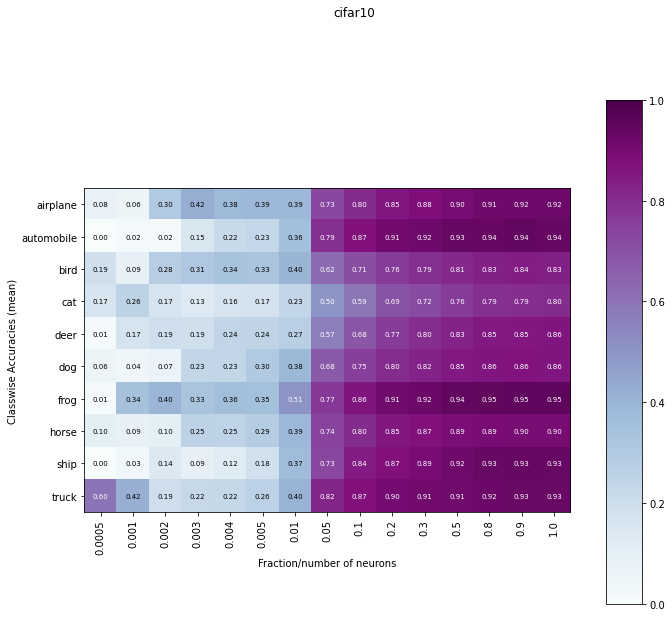

Global seed set to 2


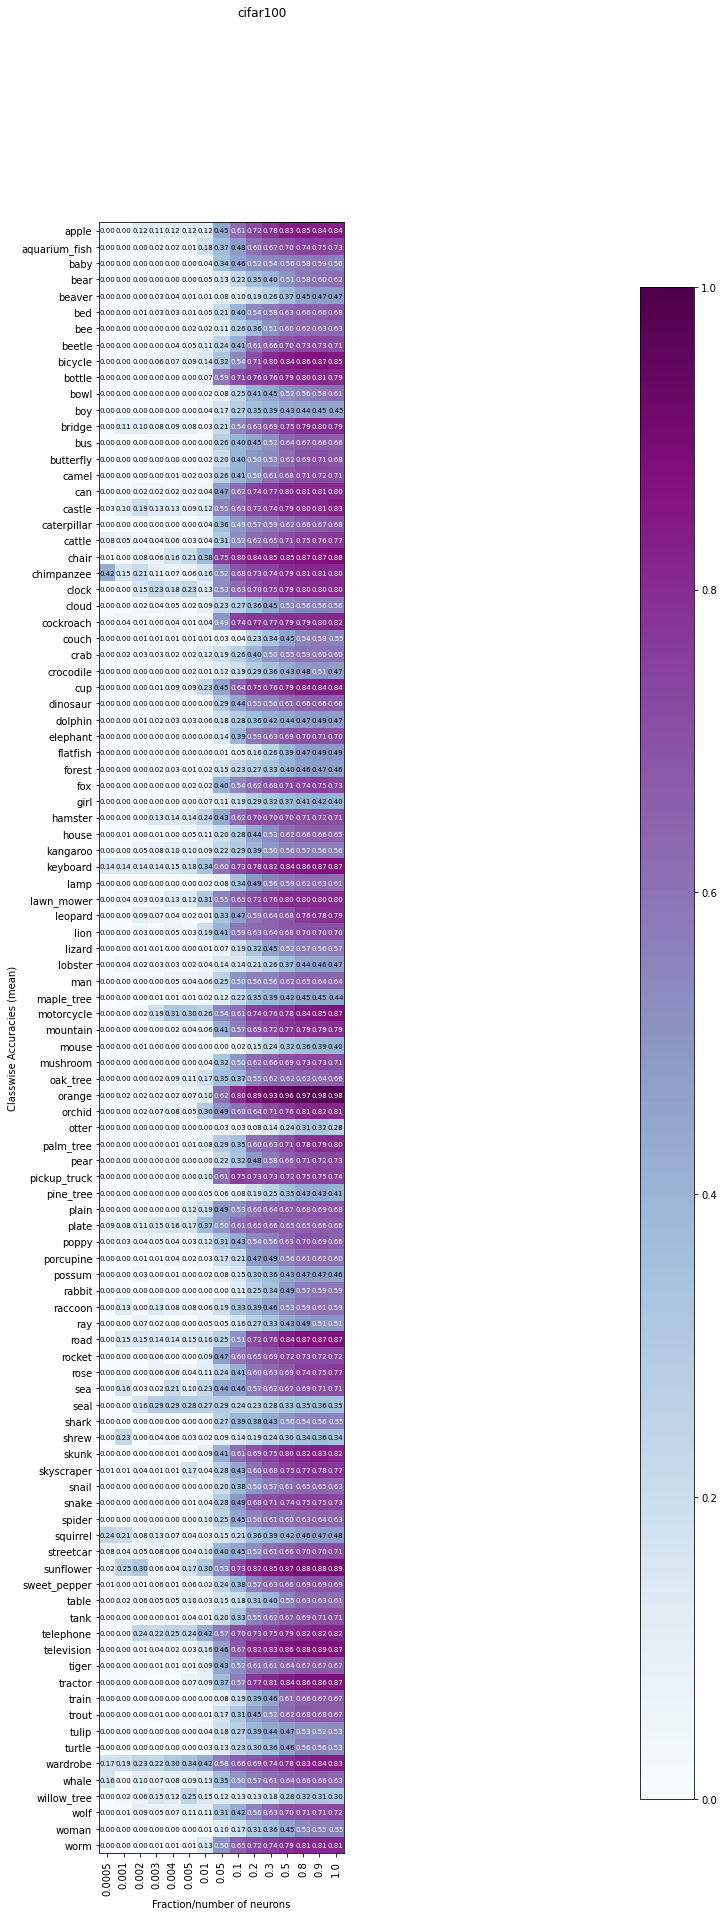

Global seed set to 2


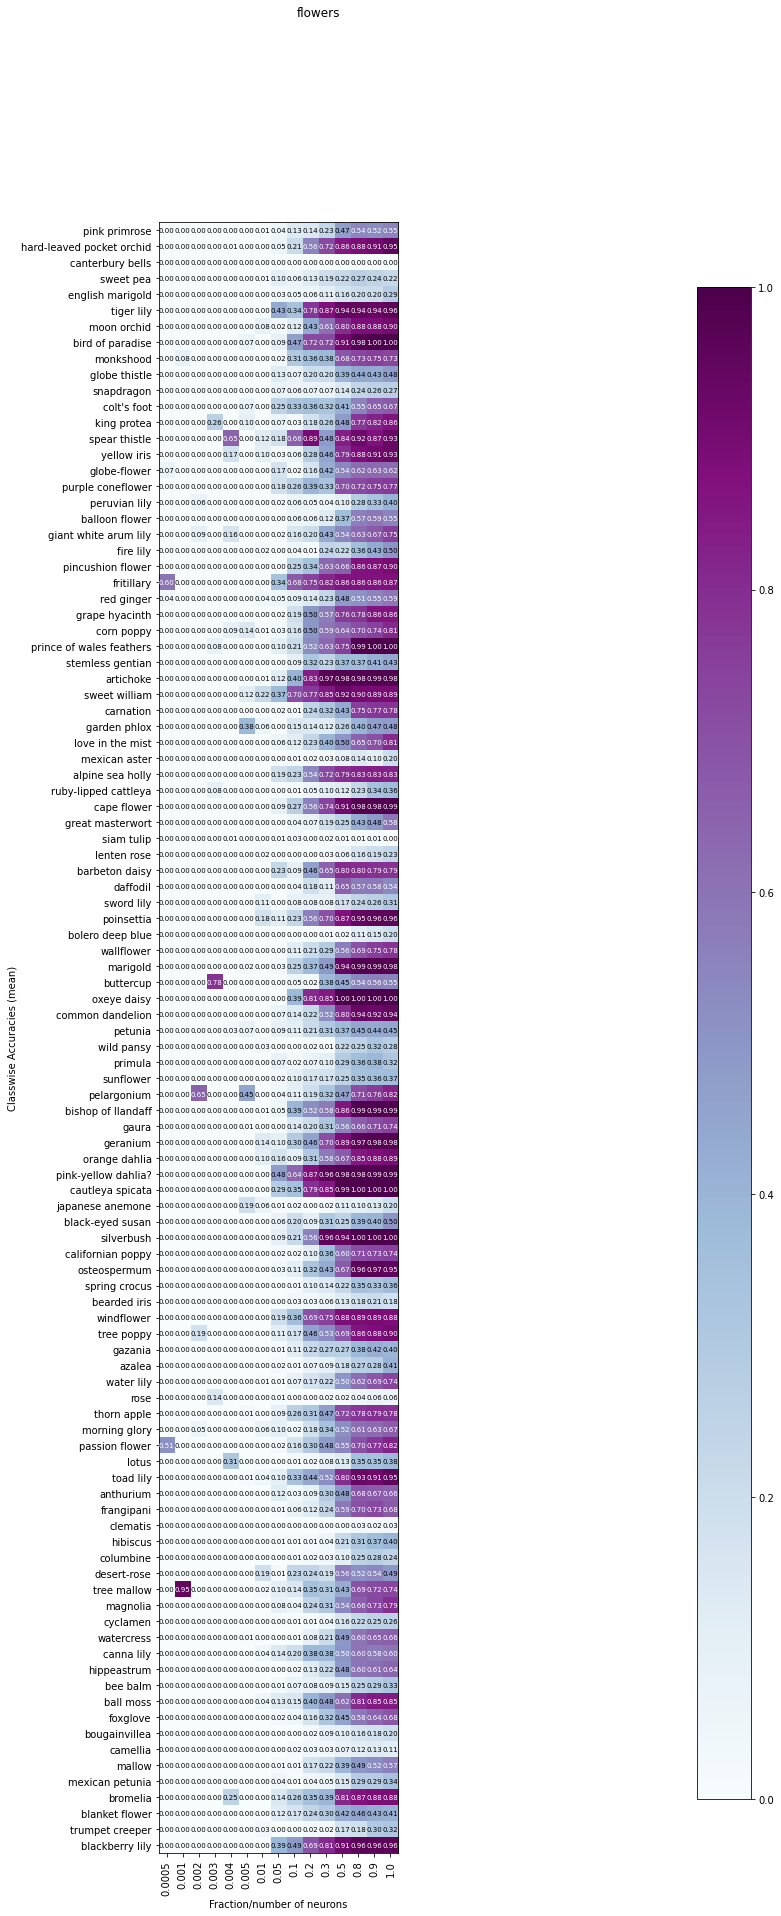

Global seed set to 2


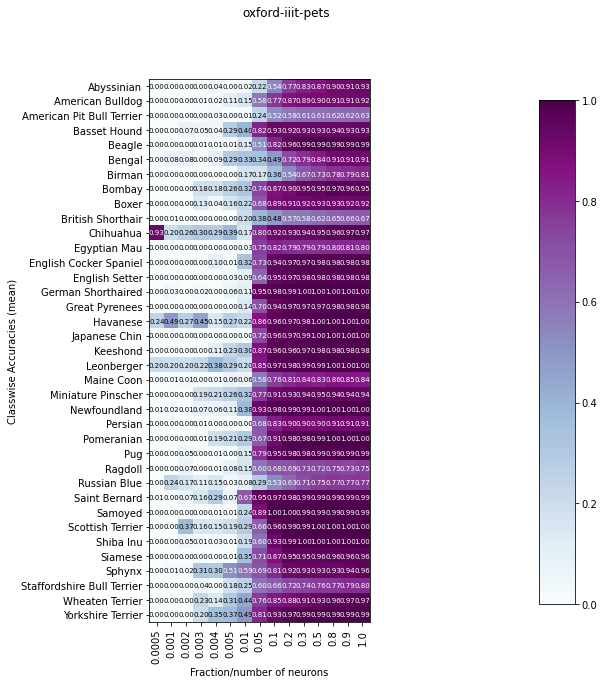

Global seed set to 2


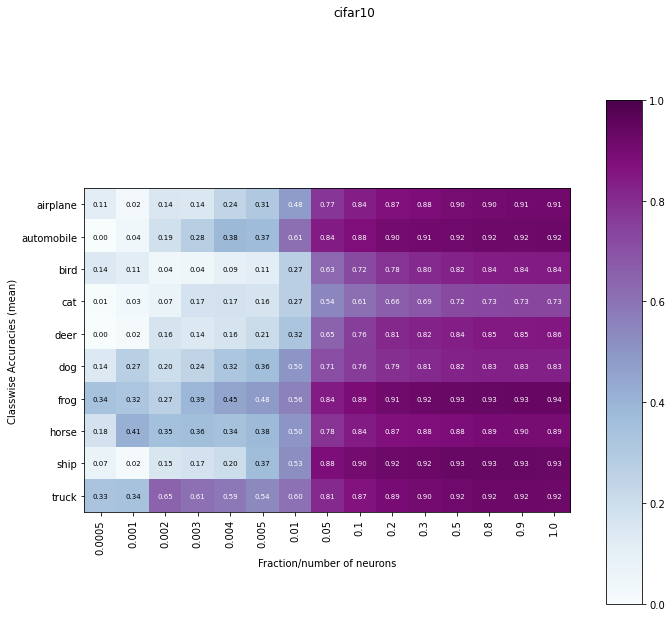

Global seed set to 2


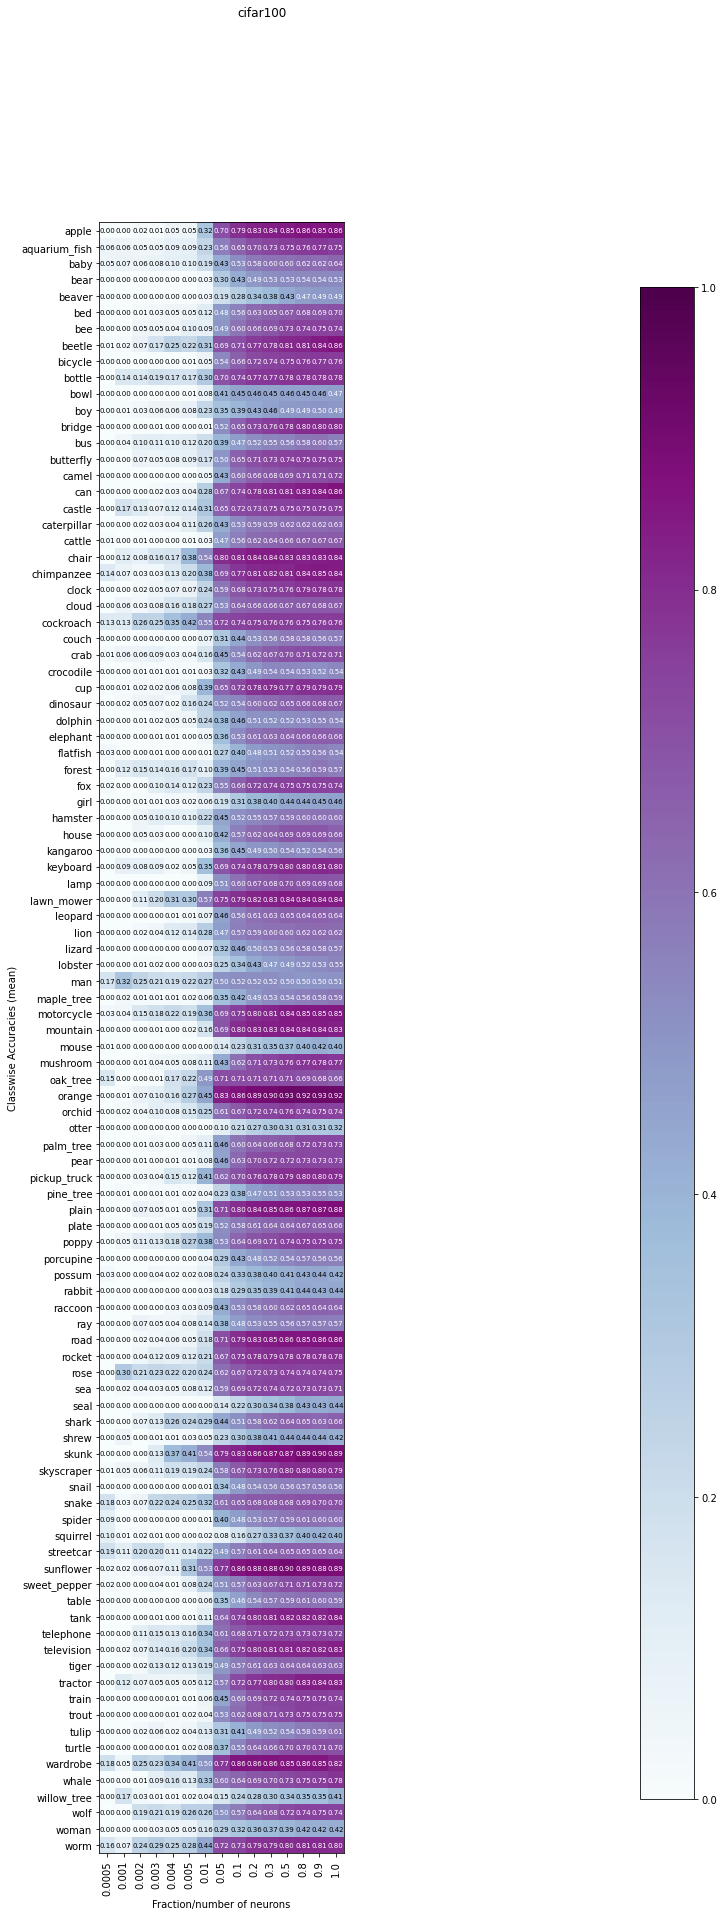

Global seed set to 2


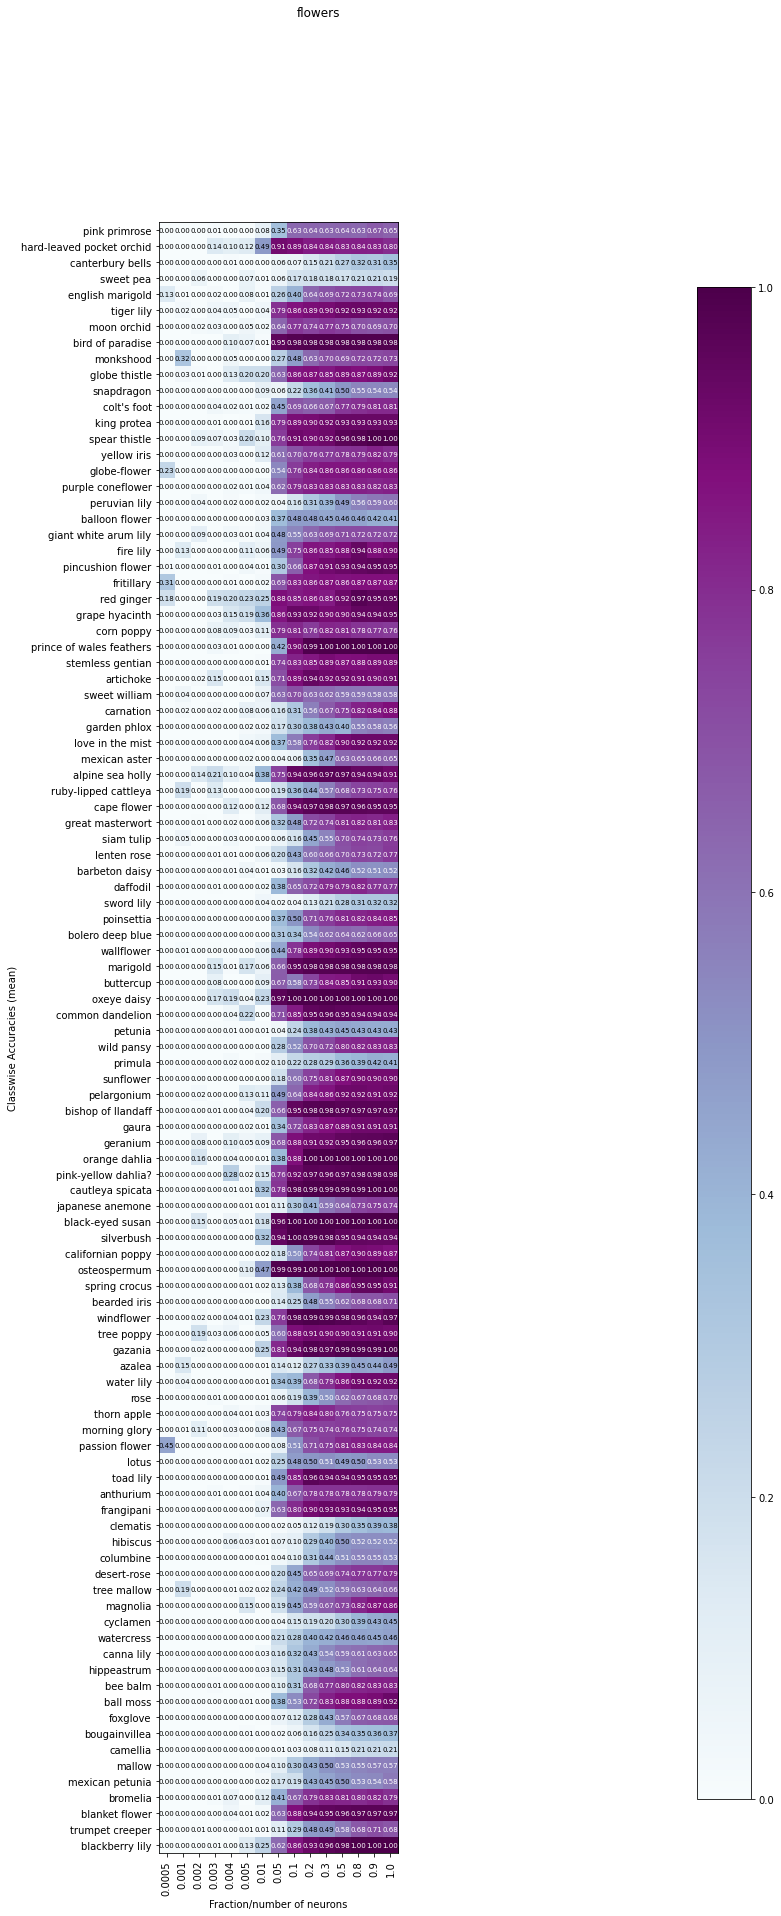

Global seed set to 2


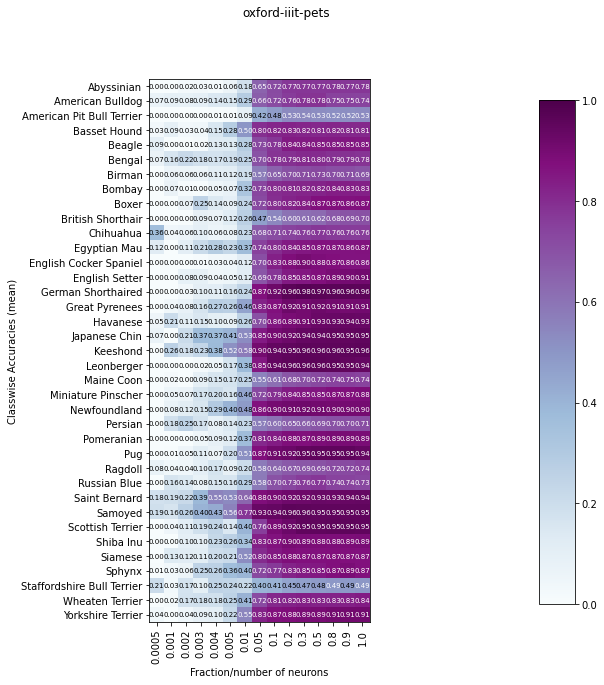

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 20 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [7]:
MODEL = 'resnet50'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'random'
resnet50_classwise_accs, resnet50_overall = results(MODEL, SOURCE_DATASET)

In [ ]:
MODEL = 'vit_small_patch32_224'
SOURCE_DATASET = 'imagenet21k'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

In [ ]:
MODEL = 'vit_small_patch16_224'
SOURCE_DATASET = 'imagenet21k'
FINETUNE_MODE = 'random'
results(MODEL, SOURCE_DATASET)

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


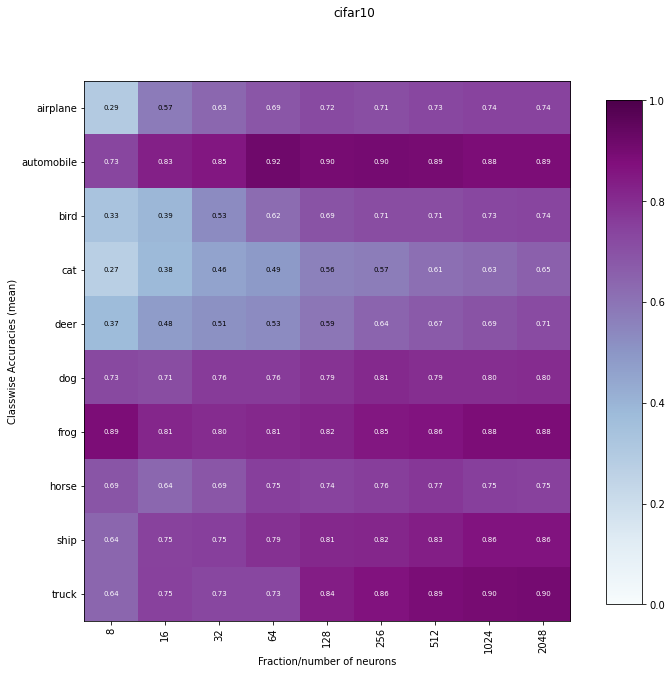

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


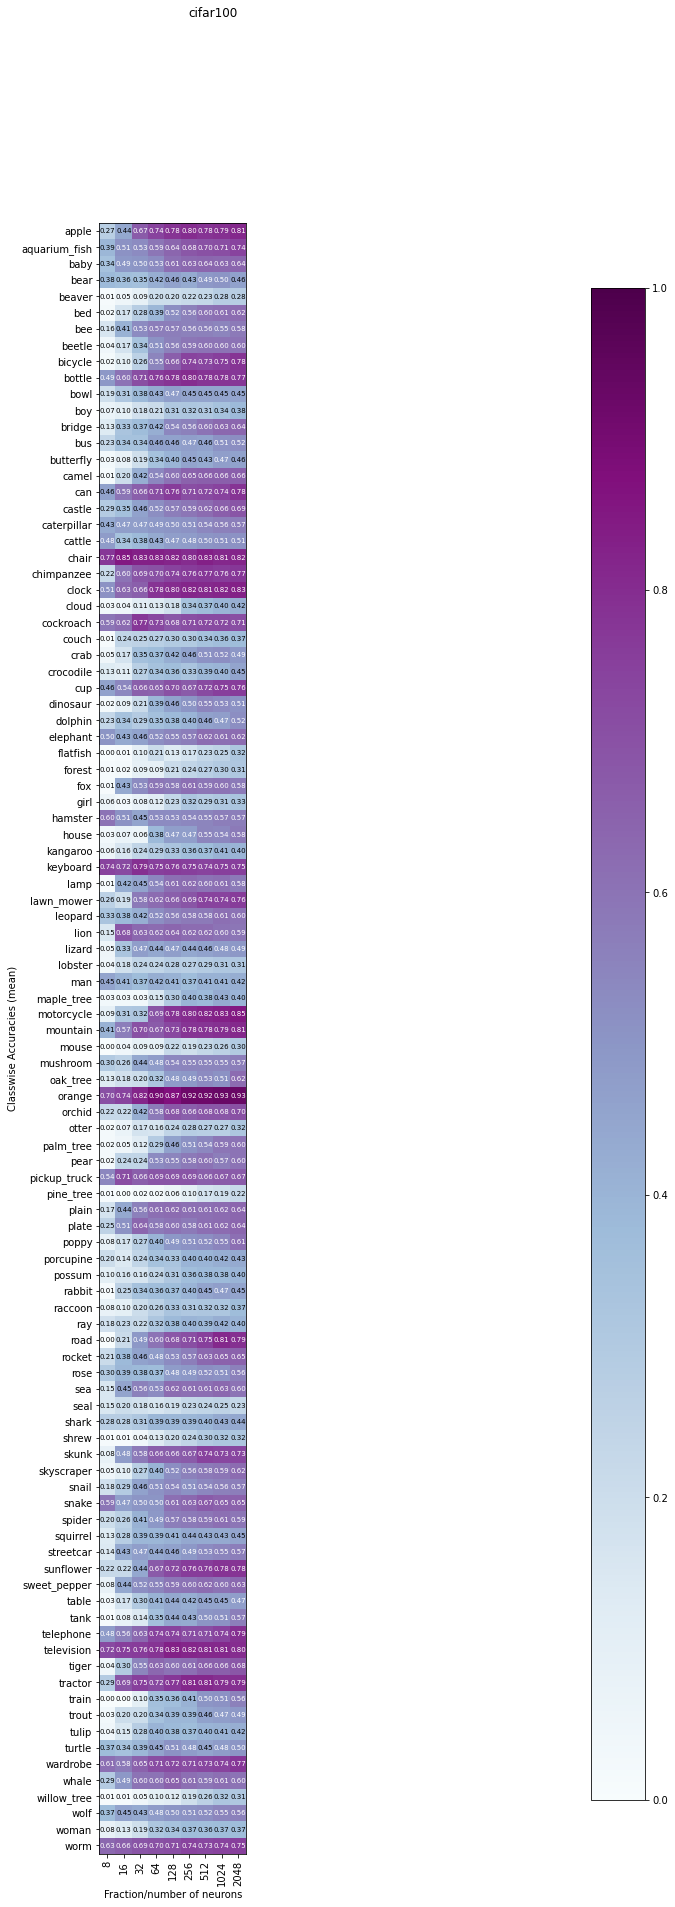

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


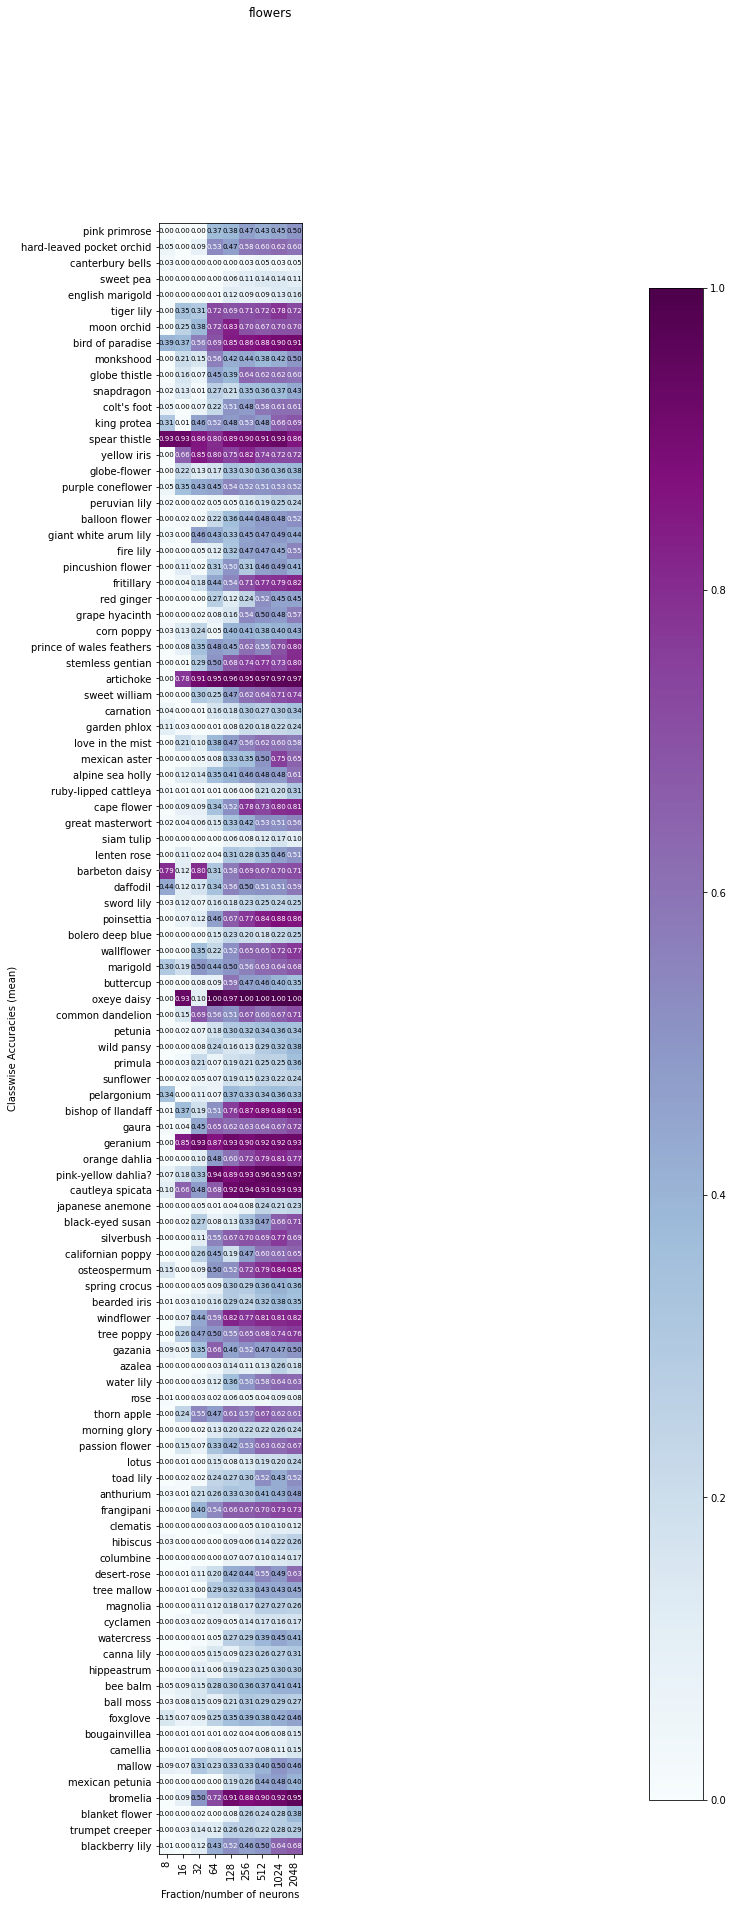

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


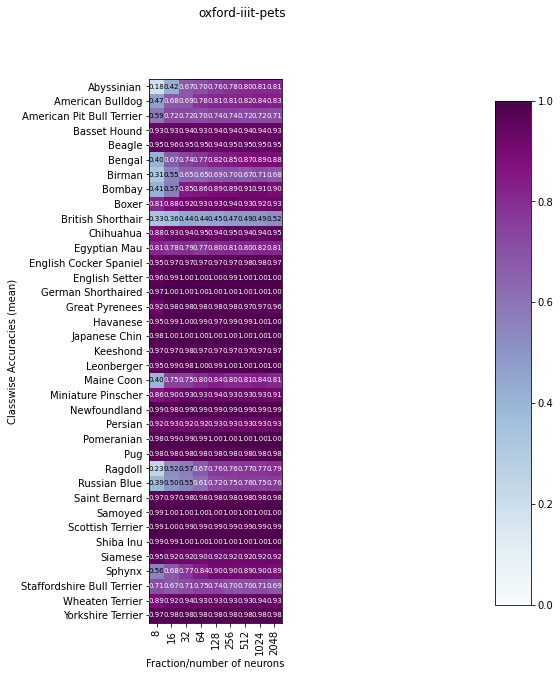

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 20 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

Global seed set to 2


copying results/class_wise_errors/imagenet/resnet50-cifar100-robustl2eps3-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-robustl2eps3-random.png
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar10-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar10-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-oxford-iiit-pets-robustl2eps3-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-oxford-iiit-pets-robustl2eps3-random.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob.png


No pretrained weights exist or were found for this model. Using random initialization.


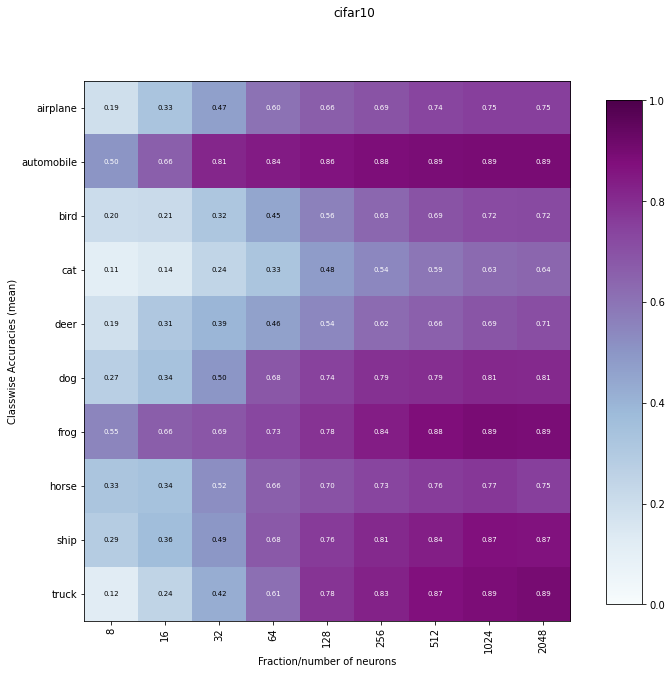

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


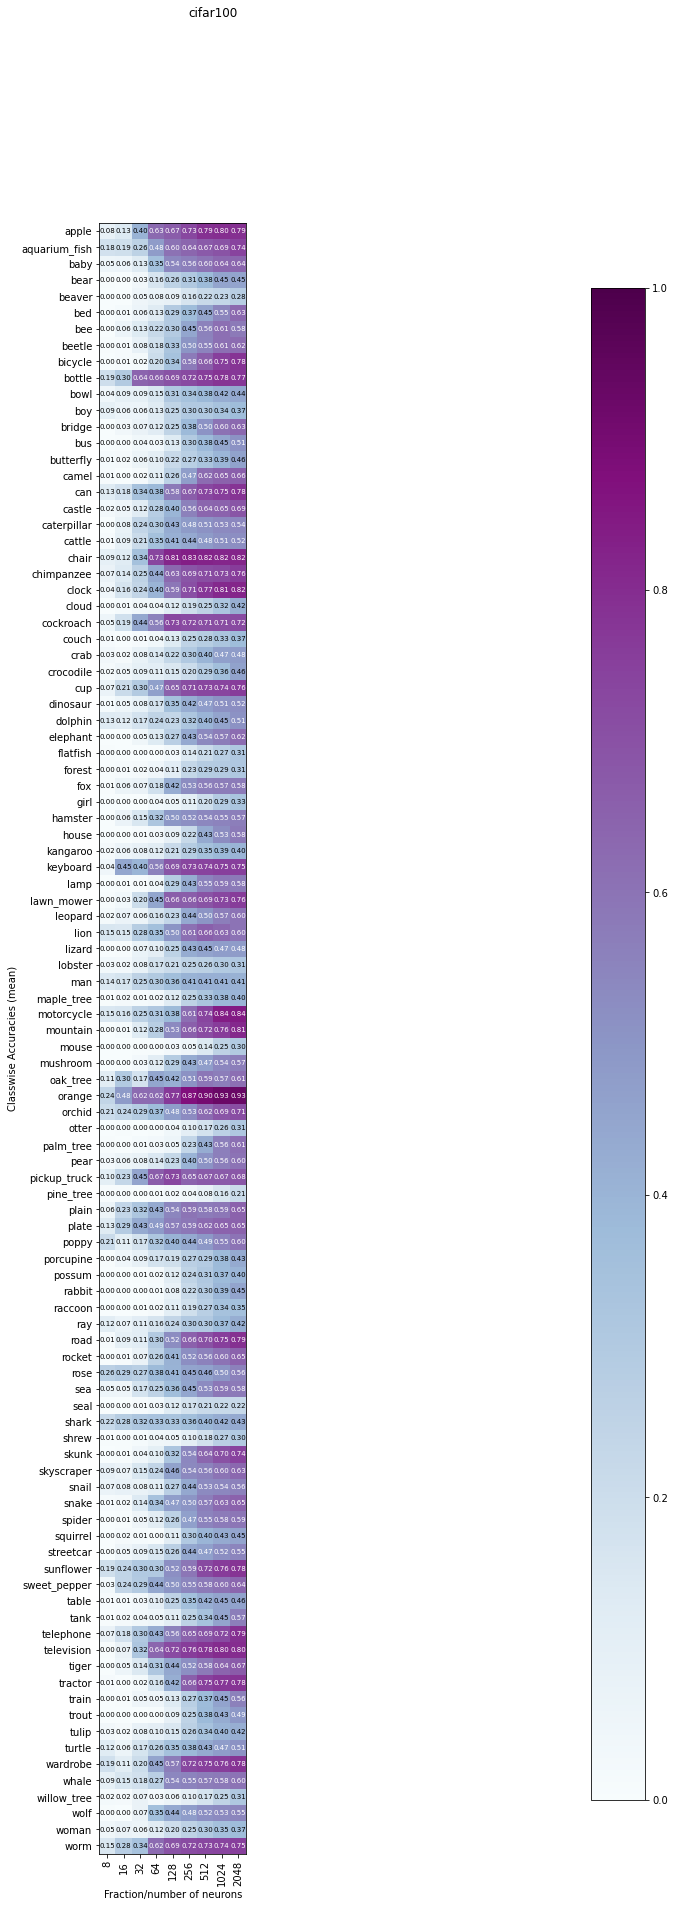

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


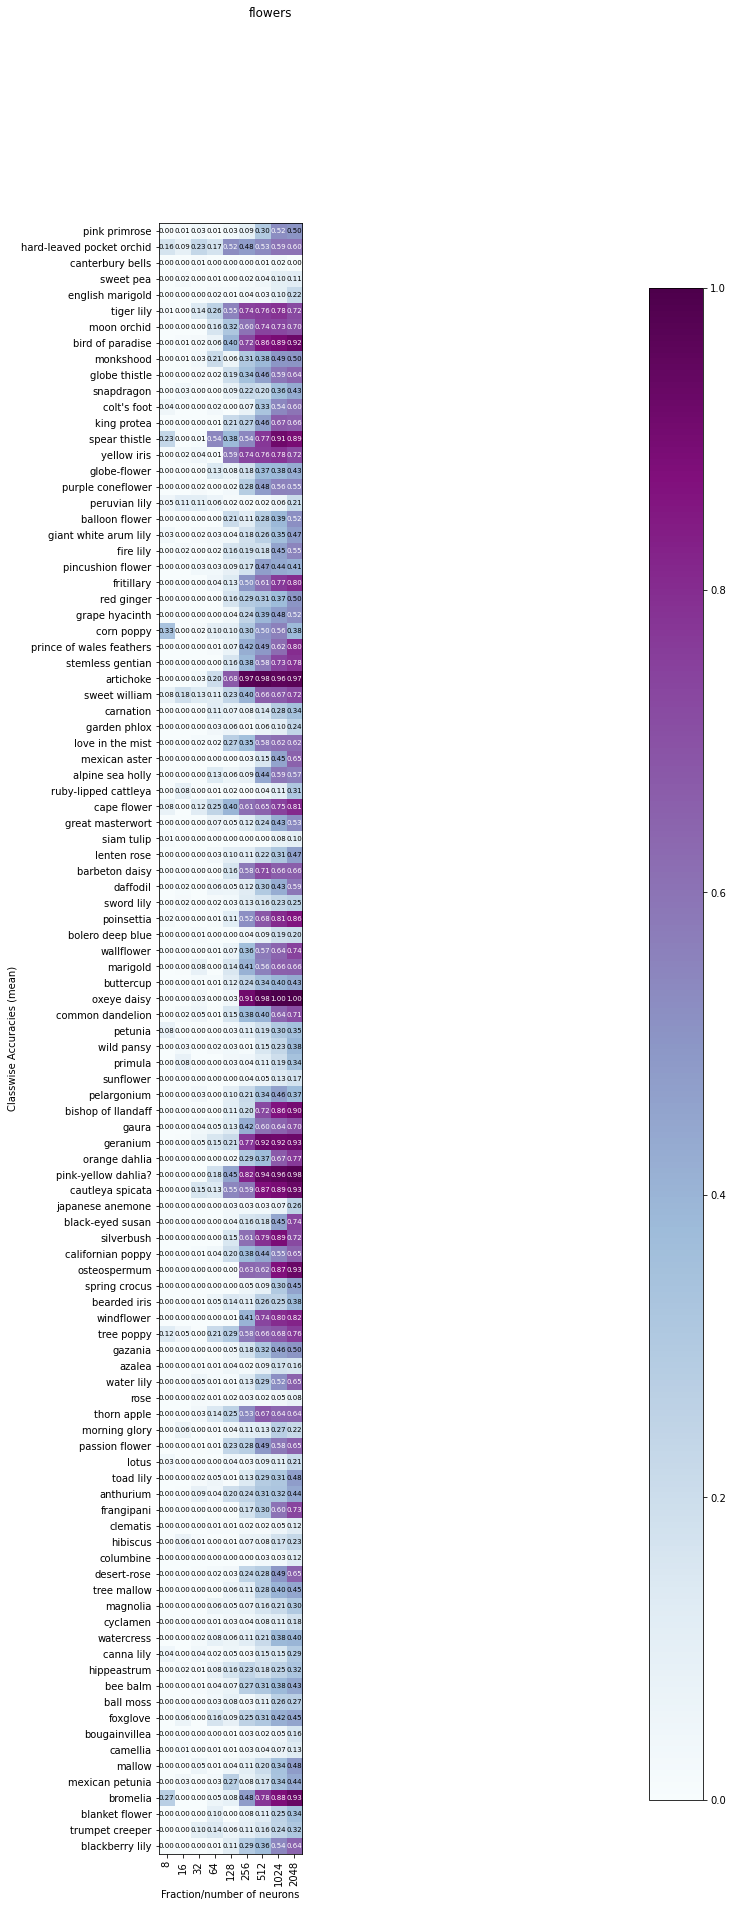

Global seed set to 2
No pretrained weights exist or were found for this model. Using random initialization.


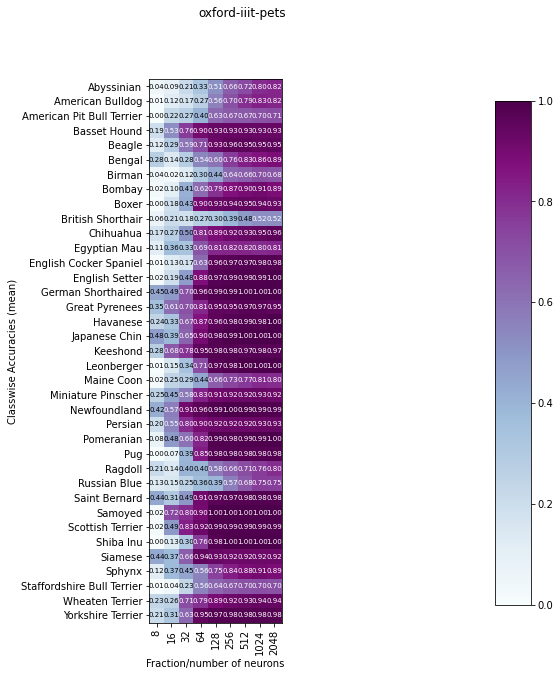

Uploading results in ['results/class_wise_errors/imagenet'] to contact.mpi-sws.org...
Uploading 24 files to server
copying results/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50_mrl-cifar100-nonrob-first.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar10-nonrob.png
copying results/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-cifar100-nonrob-random.png
copying results/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/class_wise_errors/imagenet/resnet50-flowers-robustl2eps3.png
copying results/class_wise_errors/imagenet/resnet50-cifar10-nonrob-random.png to /home/vnan

In [8]:
MODEL = 'resnet50_mrl'
SOURCE_DATASET = 'imagenet'
FINETUNE_MODE = 'first'
NUMBERS = [8,16,32,64,128,256,512,1024,2048]
resnet50mrl_classwise_accs, resnet50mrl_overall = results(MODEL, SOURCE_DATASET, FRACTIONS_OR_NUMBERS=NUMBERS)

FINETUNE_MODE = 'random'
resnet50mrl_rand_classwise_accs, \
resnet50mrl_rand_overall = results(MODEL, SOURCE_DATASET, FRACTIONS_OR_NUMBERS=NUMBERS)

[[0.12292, 0.15139999999999998, 0.18558000000000002, 0.23235999999999998, 0.25217999999999996, 0.27390000000000003, 0.3705, 0.6947600000000002, 0.77888, 0.8322600000000001, 0.85192, 0.87402, 0.8878, 0.89114, 0.8914], [0.13144, 0.15697999999999998, 0.22224, 0.25476, 0.29494, 0.3283, 0.46478, 0.74648, 0.8065800000000002, 0.8412400000000001, 0.85429, 0.86746, 0.8755200000000001, 0.8769399999999999, 0.877], [0.558, 0.6311, 0.6711, 0.7079, 0.746, 0.7631, 0.7769, 0.7865, 0.7928]] [[0.6347537964394915, 0.47276056997331706, 0.3303479095582243, 0.22924760991953522, 0.17534294103074233, 0.13982470280927983, 0.09895274543151886, 0.07661924837342422, 0.06233050391566938, 0.0468098796797788, 0.041144696512552766, 0.03574975030023594, 0.03151159394820423, 0.0310590905854937, 0.030468923114230276], [0.4885875768300413, 0.5141670811682815, 0.37077016322882234, 0.3255925986655191, 0.2741641525015611, 0.2152238279276807, 0.14667150632309892, 0.07748364357649022, 0.05814176946550033, 0.04828664909724836,

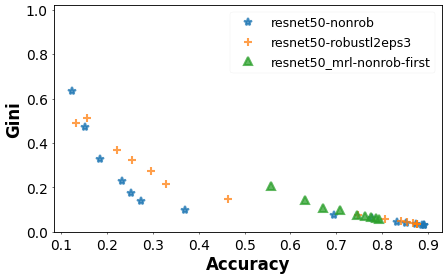

[[0.12292, 0.15139999999999998, 0.18558000000000002, 0.23235999999999998, 0.25217999999999996, 0.27390000000000003, 0.3705, 0.6947600000000002, 0.77888, 0.8322600000000001, 0.85192, 0.87402, 0.8878, 0.89114, 0.8914], [0.13144, 0.15697999999999998, 0.22224, 0.25476, 0.29494, 0.3283, 0.46478, 0.74648, 0.8065800000000002, 0.8412400000000001, 0.85429, 0.86746, 0.8755200000000001, 0.8769399999999999, 0.877], [0.558, 0.6311, 0.6711, 0.7079, 0.746, 0.7631, 0.7769, 0.7865, 0.7928]] [[1.3989179710433184, 0.8826356605519413, 0.5868613939684225, 0.40677927922989715, 0.3170553228493054, 0.2449370418659449, 0.19135511665303795, 0.1390144528072944, 0.11381217938663905, 0.0844482574390445, 0.07484902740395237, 0.06429329757157266, 0.05653914494977723, 0.05563642222693141, 0.05471775641626088], [0.8947246812859184, 0.9569962867248432, 0.745141844483678, 0.6059317511932061, 0.4885490073177863, 0.3866816748544715, 0.2689167850896583, 0.13891297209410527, 0.10778735323586507, 0.09093888084531389, 0.08245

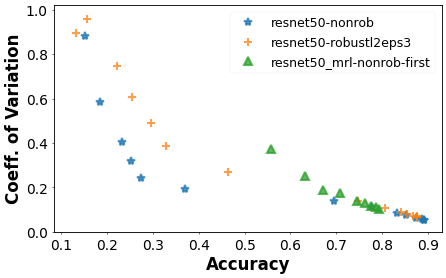

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[1.3989179710433184, 0.8826356605519413, 0.5868613939684225, 0.40677927922989715, 0.3170553228493054, 0.2449370418659449, 0.19135511665303795, 0.1390144528072944, 0.11381217938663905, 0.0844482574390445, 0.07484902740395237, 0.06429329757157266, 0.05653914494977723, 0.05563642222693141, 0.05471775641626088], [0.8947246812859184, 0.9569962867248432, 0.745141844483678, 0.6059317511932061, 0.4885490073177863, 0.3866816748544715, 0.2689167850896583, 0.13891297209410527, 0.10778735323586507, 0.09093888084531389, 0.08245984101802742, 0.07327208773563798, 0.06957010891077654, 0.06858329940492826, 0.06827618222322065], [0.3735645709459059, 0.2526729296861655, 0.1893534949993158, 0.1762341034664081, 0.1374880327529483, 0.1302181428160249,

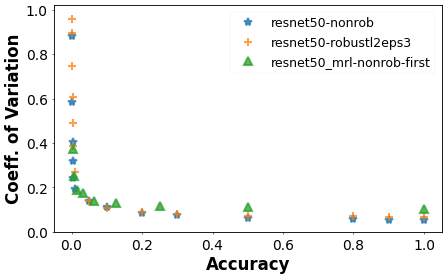

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[0.6347537964394915, 0.47276056997331706, 0.3303479095582243, 0.22924760991953522, 0.17534294103074233, 0.13982470280927983, 0.09895274543151886, 0.07661924837342422, 0.06233050391566938, 0.0468098796797788, 0.041144696512552766, 0.03574975030023594, 0.03151159394820423, 0.0310590905854937, 0.030468923114230276], [0.4885875768300413, 0.5141670811682815, 0.37077016322882234, 0.3255925986655191, 0.2741641525015611, 0.2152238279276807, 0.14667150632309892, 0.07748364357649022, 0.05814176946550033, 0.04828664909724836, 0.04339235970966264, 0.03871301699951584, 0.03631215987218665, 0.03570369747744208, 0.035553017598120934], [0.20680999486672674, 0.1419901632672873, 0.10667558797431409, 0.09822007303207245, 0.07691687524003327, 0.0733

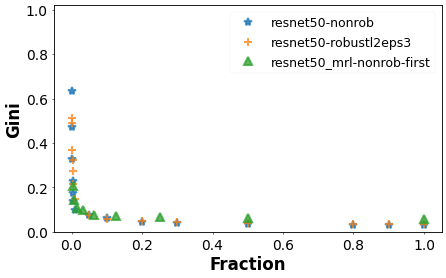

[[0.12292, 0.15139999999999998, 0.18558000000000002, 0.23235999999999998, 0.25217999999999996, 0.27390000000000003, 0.3705, 0.6947600000000002, 0.77888, 0.8322600000000001, 0.85192, 0.87402, 0.8878, 0.89114, 0.8914], [0.13144, 0.15697999999999998, 0.22224, 0.25476, 0.29494, 0.3283, 0.46478, 0.74648, 0.8065800000000002, 0.8412400000000001, 0.85429, 0.86746, 0.8755200000000001, 0.8769399999999999, 0.877], [0.558, 0.6311, 0.6711, 0.7079, 0.746, 0.7631, 0.7769, 0.7865, 0.7928]] [[0.6011999845504761, 0.3965999614447355, 0.3761999849230051, 0.33239995688199997, 0.25680000334978104, 0.2144000232219696, 0.2722000330686569, 0.3157999515533447, 0.28339993953704834, 0.22060000896453857, 0.2056000828742981, 0.18100005388259888, 0.15799999237060547, 0.15700006484985352, 0.15200001001358032], [0.33980000694282353, 0.3954000025987625, 0.6103999353945255, 0.5632000081241131, 0.49800003319978714, 0.4230000376701355, 0.3474000096321106, 0.3383999466896057, 0.2909332513809204, 0.257133424282074, 0.237533

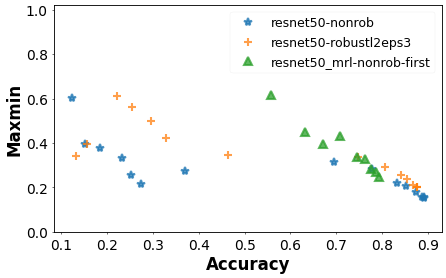

[[0.01464, 0.022420000000000002, 0.03344, 0.04004, 0.04786, 0.05392, 0.09385999999999999, 0.28966000000000003, 0.41000000000000003, 0.5175599999999999, 0.56756, 0.6233799999999999, 0.66076, 0.6676399999999999, 0.6628], [0.01802, 0.0269, 0.04466, 0.062240000000000004, 0.07782499999999999, 0.0969, 0.191075, 0.484175, 0.5728344827586207, 0.6242428571428571, 0.6456148148148148, 0.660975, 0.671, 0.6744999999999999, 0.6733], [0.2109, 0.3148, 0.3919, 0.4626, 0.5082, 0.5249, 0.5444, 0.557, 0.5694]] [[0.9371520674789442, 0.8629845534494622, 0.7726771166533024, 0.6991590943873386, 0.6786822449468305, 0.6673429781473504, 0.5451411202248299, 0.33811560668087587, 0.27821066532918404, 0.20919541764642002, 0.17551269147268928, 0.14306295979181327, 0.12542766983790354, 0.12175781886577723, 0.1254797637247148], [0.8749895958661144, 0.8097442035027934, 0.6647410106908882, 0.5944077827783938, 0.6025787336528093, 0.5739622572946617, 0.43646320286982654, 0.20717556732062128, 0.16136932887342986, 0.13928563

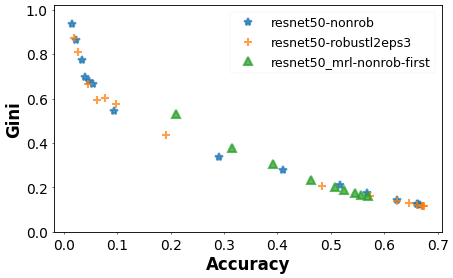

[[0.01464, 0.022420000000000002, 0.03344, 0.04004, 0.04786, 0.05392, 0.09385999999999999, 0.28966000000000003, 0.41000000000000003, 0.5175599999999999, 0.56756, 0.6233799999999999, 0.66076, 0.6676399999999999, 0.6628], [0.01802, 0.0269, 0.04466, 0.062240000000000004, 0.07782499999999999, 0.0969, 0.191075, 0.484175, 0.5728344827586207, 0.6242428571428571, 0.6456148148148148, 0.660975, 0.671, 0.6744999999999999, 0.6733], [0.2109, 0.3148, 0.3919, 0.4626, 0.5082, 0.5249, 0.5444, 0.557, 0.5694]] [[3.815653664524727, 2.390932086464888, 1.8134752462971078, 1.4940490055922475, 1.4466355311638104, 1.3899345528206122, 1.071240232759189, 0.5924935797591985, 0.4836609378047365, 0.36643320900831516, 0.308983578877826, 0.25217882029817057, 0.22184354568753353, 0.21541423943611954, 0.22234584322608844], [2.527867019168466, 2.10707882796774, 1.3998054844184096, 1.1379793666020528, 1.162391942331994, 1.0915546047675382, 0.7830282259709546, 0.3628075371499586, 0.28479813202937515, 0.2459402107536138, 0.

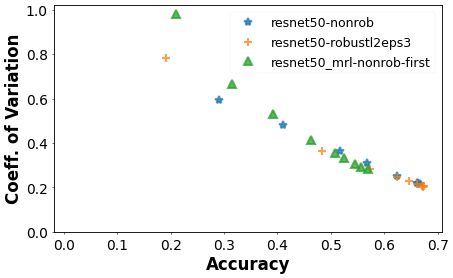

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[3.815653664524727, 2.390932086464888, 1.8134752462971078, 1.4940490055922475, 1.4466355311638104, 1.3899345528206122, 1.071240232759189, 0.5924935797591985, 0.4836609378047365, 0.36643320900831516, 0.308983578877826, 0.25217882029817057, 0.22184354568753353, 0.21541423943611954, 0.22234584322608844], [2.527867019168466, 2.10707882796774, 1.3998054844184096, 1.1379793666020528, 1.162391942331994, 1.0915546047675382, 0.7830282259709546, 0.3628075371499586, 0.28479813202937515, 0.2459402107536138, 0.2275383163257635, 0.21588031427445073, 0.20682690249147215, 0.20479867689241749, 0.20344891112555474], [0.9816588790316453, 0.665810477078475, 0.5318223626332855, 0.41340534766198733, 0.35662485261155863, 0.3327538627450156, 0.307735143

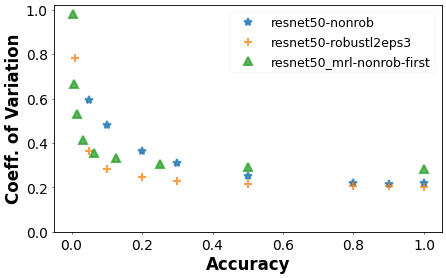

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[0.9371520674789442, 0.8629845534494622, 0.7726771166533024, 0.6991590943873386, 0.6786822449468305, 0.6673429781473504, 0.5451411202248299, 0.33811560668087587, 0.27821066532918404, 0.20919541764642002, 0.17551269147268928, 0.14306295979181327, 0.12542766983790354, 0.12175781886577723, 0.1254797637247148], [0.8749895958661144, 0.8097442035027934, 0.6647410106908882, 0.5944077827783938, 0.6025787336528093, 0.5739622572946617, 0.43646320286982654, 0.20717556732062128, 0.16136932887342986, 0.1392856307444443, 0.12886158774569395, 0.12217139353592933, 0.11731071132264838, 0.11601999732045483, 0.11561709193532016], [0.5321144947043382, 0.37959327282765554, 0.30530994976819575, 0.23555118198958575, 0.20333329204198822, 0.1899504296808

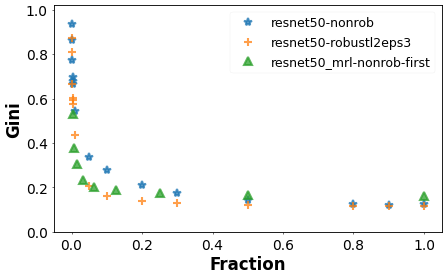

[[0.01464, 0.022420000000000002, 0.03344, 0.04004, 0.04786, 0.05392, 0.09385999999999999, 0.28966000000000003, 0.41000000000000003, 0.5175599999999999, 0.56756, 0.6233799999999999, 0.66076, 0.6676399999999999, 0.6628], [0.01802, 0.0269, 0.04466, 0.062240000000000004, 0.07782499999999999, 0.0969, 0.191075, 0.484175, 0.5728344827586207, 0.6242428571428571, 0.6456148148148148, 0.660975, 0.671, 0.6744999999999999, 0.6733], [0.2109, 0.3148, 0.3919, 0.4626, 0.5082, 0.5249, 0.5444, 0.557, 0.5694]] [[0.42399996519088745, 0.2460000067949295, 0.30399999022483826, 0.2880000174045563, 0.31200000643730164, 0.34200000762939453, 0.421999990940094, 0.7499999743886292, 0.7800000477582216, 0.8079999834299088, 0.7899999618530273, 0.7159999907016754, 0.6639999747276306, 0.6720000505447388, 0.7000000178813934], [0.1860000044107437, 0.3240000009536743, 0.25599998235702515, 0.28600001335144043, 0.3675000071525574, 0.42000001668930054, 0.5674999952316284, 0.7499999850988388, 0.6979311406612396, 0.624285757541

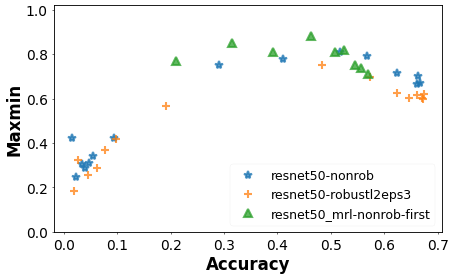

[[0.026573426573426574, 0.006212392258903887, 0.008619287689055132, 0.012229630834282, 0.014116116441697838, 0.01356318100504147, 0.0155472434542202, 0.06492112538624166, 0.13374532444299886, 0.24143763213530658, 0.3273052528866482, 0.4753293218409498, 0.5671166043259067, 0.5921613270450481, 0.6093673768092372], [0.02299560904212067, 0.009269799967474386, 0.00907464628394861, 0.010831029435680598, 0.019873150105708243, 0.020100829403154986, 0.05135794438120019, 0.3445113026508375, 0.508245243128964, 0.6200032525613921, 0.6631322166205887, 0.7022605301675069, 0.7256139209627582, 0.7309155960318751, 0.7342657342657343], [0.04548165013281292, 0.0909090909090909, 0.18355288122729982, 0.27966607036374475, 0.37193039518620913, 0.42370033067707485, 0.46422182468694095, 0.490404943893316, 0.506586436818995]] [[0.9779709354822677, 0.9885786027608214, 0.9753532102803498, 0.9739943371494892, 0.9582095682271758, 0.9399303355040599, 0.8618411484043385, 0.6524073586767645, 0.5568813078440813, 0.4937

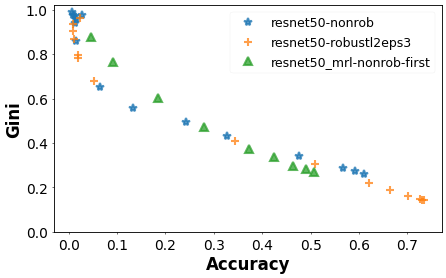

[[0.026573426573426574, 0.006212392258903887, 0.008619287689055132, 0.012229630834282, 0.014116116441697838, 0.01356318100504147, 0.0155472434542202, 0.06492112538624166, 0.13374532444299886, 0.24143763213530658, 0.3273052528866482, 0.4753293218409498, 0.5671166043259067, 0.5921613270450481, 0.6093673768092372], [0.02299560904212067, 0.009269799967474386, 0.00907464628394861, 0.010831029435680598, 0.019873150105708243, 0.020100829403154986, 0.05135794438120019, 0.3445113026508375, 0.508245243128964, 0.6200032525613921, 0.6631322166205887, 0.7022605301675069, 0.7256139209627582, 0.7309155960318751, 0.7342657342657343], [0.04548165013281292, 0.0909090909090909, 0.18355288122729982, 0.27966607036374475, 0.37193039518620913, 0.42370033067707485, 0.46422182468694095, 0.490404943893316, 0.506586436818995]] [[6.507718365792579, 9.25445299598119, 6.531486868756416, 6.248384624341781, 4.7192267487620905, 3.949985520237744, 2.427546097930192, 1.3892380548730092, 1.0950907201264632, 0.90312195917

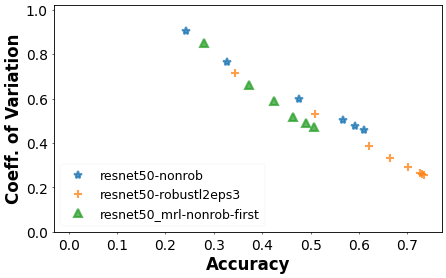

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[6.507718365792579, 9.25445299598119, 6.531486868756416, 6.248384624341781, 4.7192267487620905, 3.949985520237744, 2.427546097930192, 1.3892380548730092, 1.0950907201264632, 0.9031219591794635, 0.7633893065443725, 0.5969059539525996, 0.5037431422485684, 0.4781810367899747, 0.4586096847147079], [4.77169224915827, 3.789851118098008, 2.948038746044658, 2.541083162396635, 1.9974651612953773, 1.8800741867881903, 1.49488508154084, 0.7149990721125111, 0.5289094919534397, 0.3869150976121716, 0.33375097380301066, 0.29215412634208254, 0.2669835612059776, 0.2612800334549268, 0.25847874012476263], [2.946664129779701, 1.899260199495065, 1.208028582778473, 0.8509804430390632, 0.6625799899494311, 0.5883487381205552, 0.5182593274851895, 0.491382

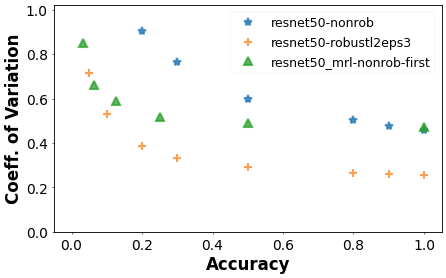

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[0.9779709354822677, 0.9885786027608214, 0.9753532102803498, 0.9739943371494892, 0.9582095682271758, 0.9399303355040599, 0.8618411484043385, 0.6524073586767645, 0.5568813078440813, 0.49374664086479125, 0.4298592256349174, 0.3438129943247538, 0.2892387165604439, 0.2735467707104136, 0.261528736554984], [0.9618998669092111, 0.9367720878626236, 0.9054865532916184, 0.8688805975307519, 0.7948968236898856, 0.7832180163281622, 0.6794797497360864, 0.40844343984466525, 0.303585551588395, 0.21884987085556007, 0.18655844534822938, 0.16165899337908451, 0.14711350247081403, 0.1435319948842187, 0.14196580480565102], [0.8784184071300112, 0.7647116060344876, 0.6040443457740435, 0.4724728339148004, 0.37457150337352674, 0.3366662238304853, 0.296839

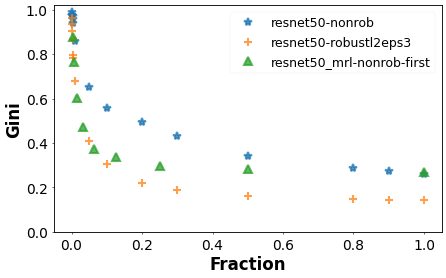

[[0.026573426573426574, 0.006212392258903887, 0.008619287689055132, 0.012229630834282, 0.014116116441697838, 0.01356318100504147, 0.0155472434542202, 0.06492112538624166, 0.13374532444299886, 0.24143763213530658, 0.3273052528866482, 0.4753293218409498, 0.5671166043259067, 0.5921613270450481, 0.6093673768092372], [0.02299560904212067, 0.009269799967474386, 0.00907464628394861, 0.010831029435680598, 0.019873150105708243, 0.020100829403154986, 0.05135794438120019, 0.3445113026508375, 0.508245243128964, 0.6200032525613921, 0.6631322166205887, 0.7022605301675069, 0.7256139209627582, 0.7309155960318751, 0.7342657342657343], [0.04548165013281292, 0.0909090909090909, 0.18355288122729982, 0.27966607036374475, 0.37193039518620913, 0.42370033067707485, 0.46422182468694095, 0.490404943893316, 0.506586436818995]] [[0.597183108329773, 0.9473684430122375, 0.6470588445663452, 0.7843137979507446, 0.6500000357627869, 0.45098042488098145, 0.21538463234901428, 0.47640448808670044, 0.7046154141426086, 0.89

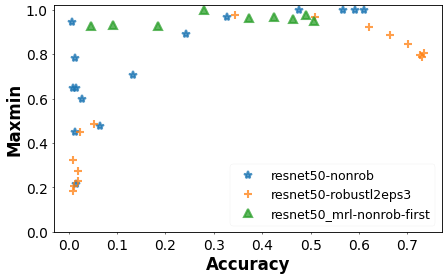

[[0.038103025347506134, 0.03521395475606433, 0.04666121559007904, 0.07762333060779504, 0.09174161896974653, 0.12968111201962387, 0.22938130280730445, 0.6634505314799672, 0.8272008721722541, 0.8811120196238758, 0.9004633415099482, 0.9107113654946852, 0.9212864540746798, 0.9223221586263287, 0.9250476969201418], [0.041700735895339326, 0.05821749795584628, 0.08863450531479967, 0.13360588716271465, 0.17138184791496322, 0.20179885527391658, 0.3496865630962115, 0.7213954756064322, 0.783047151812483, 0.8175524666121561, 0.8268738075769966, 0.8323248841646225, 0.8342327609702916, 0.8352139547560643, 0.8351049332243118], [0.7715090397020078, 0.839329517579722, 0.8697192695557372, 0.8817116380485146, 0.8973834832379395, 0.8992913600436085, 0.9005178522758245, 0.9044698828018534, 0.901880621422731]] [[0.944203509825842, 0.8851874321765237, 0.7982719232346143, 0.7044816058722062, 0.6257012645784398, 0.5776155283896304, 0.3803189514284231, 0.16641901571635834, 0.10653593313797927, 0.0774580185249232

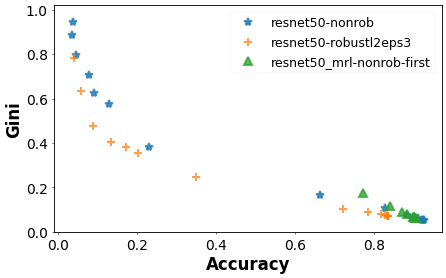

[[0.038103025347506134, 0.03521395475606433, 0.04666121559007904, 0.07762333060779504, 0.09174161896974653, 0.12968111201962387, 0.22938130280730445, 0.6634505314799672, 0.8272008721722541, 0.8811120196238758, 0.9004633415099482, 0.9107113654946852, 0.9212864540746798, 0.9223221586263287, 0.9250476969201418], [0.041700735895339326, 0.05821749795584628, 0.08863450531479967, 0.13360588716271465, 0.17138184791496322, 0.20179885527391658, 0.3496865630962115, 0.7213954756064322, 0.783047151812483, 0.8175524666121561, 0.8268738075769966, 0.8323248841646225, 0.8342327609702916, 0.8352139547560643, 0.8351049332243118], [0.7715090397020078, 0.839329517579722, 0.8697192695557372, 0.8817116380485146, 0.8973834832379395, 0.8992913600436085, 0.9005178522758245, 0.9044698828018534, 0.901880621422731]] [[4.141515514172915, 2.7466157034427936, 1.929592628165162, 1.4548526082610447, 1.20621483046453, 1.0691502824879784, 0.6866523974185473, 0.30631758901092415, 0.20671520202312257, 0.15200931814363622, 

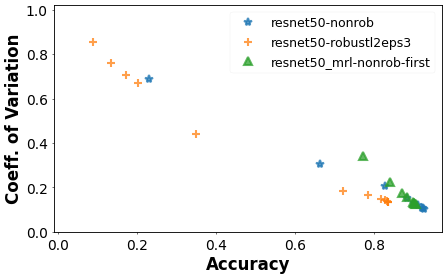

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[4.141515514172915, 2.7466157034427936, 1.929592628165162, 1.4548526082610447, 1.20621483046453, 1.0691502824879784, 0.6866523974185473, 0.30631758901092415, 0.20671520202312257, 0.15200931814363622, 0.12915332224550416, 0.11911484378112186, 0.10929456185309779, 0.10803094316929811, 0.10431908808472692], [1.8525895657687825, 1.2330108335233765, 0.8546389657282073, 0.7594994742733664, 0.7064559741789931, 0.671822191090099, 0.4410486976295967, 0.18368500329062362, 0.1647983513504942, 0.1464254680441735, 0.14313260544221773, 0.13877849776799617, 0.1363906734804858, 0.1358743000341772, 0.13399656806405097], [0.34151070827364943, 0.22519163794541408, 0.17403940373192678, 0.15586834327097357, 0.1330946333055436, 0.130736099743826, 0.13

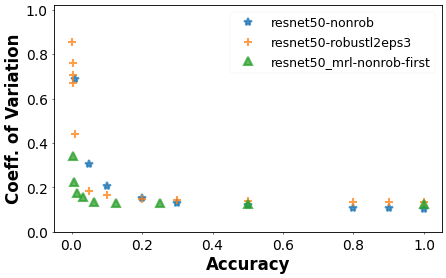

[[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9, 1.0], [0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]] [[0.944203509825842, 0.8851874321765237, 0.7982719232346143, 0.7044816058722062, 0.6257012645784398, 0.5776155283896304, 0.3803189514284231, 0.16641901571635834, 0.10653593313797927, 0.07745801852492322, 0.0656110041869107, 0.060385297067924996, 0.054051378245304205, 0.053433346450997676, 0.05153392478485743], [0.782138609438517, 0.6362047029150381, 0.47507845143024624, 0.40614121787797175, 0.3811883617222439, 0.35719876716772153, 0.24671266008310042, 0.10213851500423103, 0.08916027033295432, 0.07837376601065094, 0.07639145483474909, 0.07370792287803082, 0.07231723974958684, 0.07198448662466295, 0.07122870873274183], [0.1764058081880533, 0.11715571826517461, 0.09030299669855373, 0.08041174446449992, 0.06699700073603977, 0.06616246

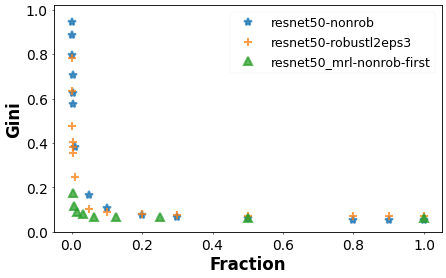

[[0.038103025347506134, 0.03521395475606433, 0.04666121559007904, 0.07762333060779504, 0.09174161896974653, 0.12968111201962387, 0.22938130280730445, 0.6634505314799672, 0.8272008721722541, 0.8811120196238758, 0.9004633415099482, 0.9107113654946852, 0.9212864540746798, 0.9223221586263287, 0.9250476969201418], [0.041700735895339326, 0.05821749795584628, 0.08863450531479967, 0.13360588716271465, 0.17138184791496322, 0.20179885527391658, 0.3496865630962115, 0.7213954756064322, 0.783047151812483, 0.8175524666121561, 0.8268738075769966, 0.8323248841646225, 0.8342327609702916, 0.8352139547560643, 0.8351049332243118], [0.7715090397020078, 0.839329517579722, 0.8697192695557372, 0.8817116380485146, 0.8973834832379395, 0.8992913600436085, 0.9005178522758245, 0.9044698828018534, 0.901880621422731]] [[0.9259999990463257, 0.4880000054836273, 0.3737373948097229, 0.45399999618530273, 0.37599998712539673, 0.5139999985694885, 0.6699999570846558, 0.7819999903440475, 0.6399999856948853, 0.462000012397766

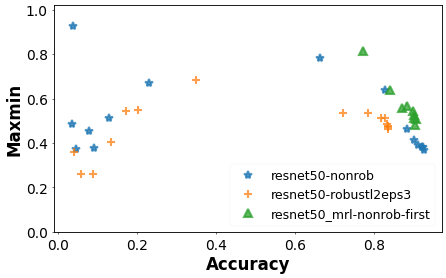

In [25]:
models_to_compare = ['resnet50-nonrob', 'resnet50-robustl2eps3', 'resnet50_mrl-nonrob']
model_results = [(resnet50_classwise_accs, resnet50_overall),
                 (resnet50_classwise_accs, resnet50_overall),
                 (resnet50mrl_classwise_accs, resnet50mrl_overall)]
#                  (resnet50mrl_rand_classwise_accs, resnet50mrl_rand_overall)]
appends = ['', '', '-first'] #, '-rand']
model_str = 'resnet50_vs_mrl'

for ft_ds in FINETUNING_DATASETS:
    model_wise_x, model_wise_x_frac = [], []
    model_wise_gini, model_wise_maxmin, model_wise_tv = [], [], []
    legend_vals = []
    for model, append, (model_results_classwise, model_results_overall) in \
        zip(models_to_compare, appends, model_results):
        x_vals, x_vals_frac = [], []
        ginis, maxmins, tvs = [], [], []
        if f'{model}-{ft_ds}' in model_results_overall:
            for idx, key in enumerate(sorted(model_results_overall[f'{model}-{ft_ds}'].keys())):
                x_vals.append(np.nanmean(model_results_overall[f'{model}-{ft_ds}'][key]))
                x_vals_frac.append(key if isinstance(key, float) else key/2048.)
                ginis.append(gini(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
                maxmins.append(maxmin(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
                tvs.append(tv(model_results_classwise[f'{model}-{ft_ds}'][:,idx]))
            model_wise_x.append(x_vals)
            model_wise_x_frac.append(x_vals_frac)
            model_wise_gini.append(ginis)
            model_wise_tv.append(tvs)
            model_wise_maxmin.append(maxmins)
            legend_vals.append(f'{model}{append}')
    plt_hp.line_plot(
        model_wise_gini, 
        'Accuracy', 'Gini', '', 
        subfolder=SOURCE_DATASET, filename=f'gini_vs_acc_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_gini), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None)
    
    plt_hp.line_plot(
        model_wise_tv, 
        'Accuracy', 'Coeff. of Variation', '', 
        subfolder=SOURCE_DATASET, filename=f'tv_vs_acc_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_tv), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None)
    
    plt_hp.line_plot(
        model_wise_tv, 
        'Accuracy', 'Coeff. of Variation', '', 
        subfolder=SOURCE_DATASET, filename=f'tv_vs_frac_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x_frac, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_tv), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None)


    plt_hp.line_plot(
        model_wise_gini, 
        'Fraction', 'Gini', '', 
        subfolder=SOURCE_DATASET, filename=f'gini_vs_frac_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x_frac, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_gini), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None)

    plt_hp.line_plot(
        model_wise_maxmin, 
        'Accuracy', 'Maxmin', '', 
        subfolder=SOURCE_DATASET, filename=f'maxmin_vs_acc_{model_str}-{ft_ds}', 
        extension='png', x_vals=model_wise_x, legend_vals=legend_vals, vertical_line=None, 
        linestyles=['']*len(model_wise_maxmin), 
        y_lims=(0.,1.02), root_dir='.', paper_friendly_plots=True, 
        plot_inside=True, legend_location='best', savefig=True, figsize=(10,6), 
        marker=['*', '+', '^', 'o'], results_subfolder_name='class_wise_errors', 
        grid_spacing=None, y_err=None, legend_ncol=None)